In [ ]:
import geopandas as gpd
import numpy as np
import shapely
import rasterio
from shapely.geometry import Point
from matplotlib import pyplot as plt

from rasterio.plot import show

import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# testing for branches

In [58]:
# Define file paths
sipit_centerline_path = r'D:/AMH Philippines, Inc/PP23.307 Rockwell and Roll - General/06 NP23.000 WORK FILES/Richmond/My Documents/Python/amh_pyqgis/flow_extraction/Sipit_RAS/GIS/merged_cl.shp'
baranca_ref_line_shp_path = r"D:\AMH Philippines, Inc\PP23.307 Rockwell and Roll - General\06 NP23.000 WORK FILES\Richmond\My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\GIS\Reference Lines\baranca.shp"

terrain_path = r"D:\AMH Philippines, Inc\PP23.307 Rockwell and Roll - General\06 NP23.000 WORK FILES\Richmond\My Documents\Python\amh_pyqgis\flow_extraction\Sipit_RAS\Terrain\Terrain.Client Topo.tif"


[71.99219]
[69.22656]
[65.50781]
[64.046875]
[63.757812]
[87.55469]
[84.34375]
[78.08594]
[92.]
[92.97656]


C:\Users\AMH-L156\AppData\Local\Temp\ipykernel_74240\3596113626.py:32: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  valid_points.plot(ax=ax, color='black')


TransformError: Invalid inputs

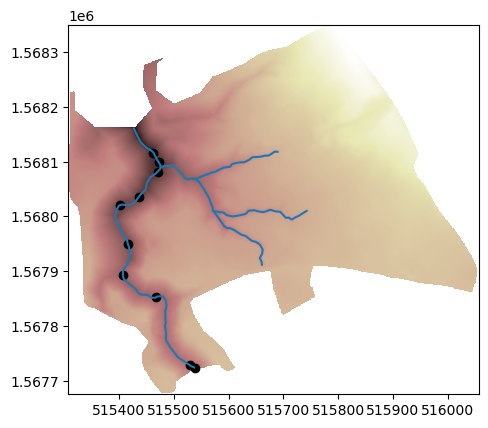

In [131]:
fig, ax = plt.subplots()
gdf_sipit = gpd.read_file(sipit_centerline_path).to_crs('EPSG:3123')
gdf_sipit.plot(ax=ax)

gdf_baranca_ref_line = gpd.read_file(baranca_ref_line_shp_path).to_crs('EPSG:3123')
# gdf_baranca_ref_line.plot(ax=ax)

# i=0
# for i in range(0,1):
#     ref_line = gdf_baranca_ref_line.iloc[11].geometry
#     point = shapely.intersection(ref_line, gdf_sipit.geometry)
#     point.plot(ax=ax, color='black')

# valid_pts = point[
#     point.notna()                      # drop None/NaT
#     & ~point.is_empty                  # drop EMPTY
#     & (point.geom_type == "Point")     # keep only Points
# ]
# valid_pts.x


with rasterio.open(terrain_path) as src:
    # transform rasterio plot
    extent = [src.bounds[0], src.bounds[1], src.bounds[2], src.bounds[3]]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')

    i=0
    for i in range(0,32):
        ref_line = gdf_baranca_ref_line.iloc[i].geometry
        point = shapely.intersection(ref_line, gdf_sipit.geometry)
        valid_points = point[point.notna() & ~point.is_empty & (point.geom_type == 'Point')]
        valid_points.plot(ax=ax, color='black')

        x_coor = valid_points.x
        y_coor = valid_points.y
        coord_list = [(x_coor, y_coor)]
        sampled_raster = np.array([arr[0] for arr in src.sample(coord_list)])
        print(sampled_raster)